In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D



In [2]:
df = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
# Groupby subjects
by_drivers = df.groupby('subject') 
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [4]:
num_classes = 10

In [5]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):
    
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

#Loading training dataset
def train_data_load(img_rows=64, img_cols=64, color_type=3):
    train_images=[]
    train_labels=[]
    
    #Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

#Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids
    

In [6]:
pip install np_utils


     |████████████████████████████████| 61 kB 290 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=675ad576eb455350a1f9f98a4b96c9481941ff06278b9f29a907f94da0b728ea
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils
Note: you may need to restart the kernel to use updated packages.


In [7]:
img_rows = 64
img_cols = 64
color_type = 1
nb_test_samples = 200

#Loading train images 
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images 
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:26<03:57, 26.43s/it]

Loading directory c1


 20%|██        | 2/10 [00:49<03:14, 24.28s/it]

Loading directory c2


 30%|███       | 3/10 [01:12<02:46, 23.75s/it]

Loading directory c3


 40%|████      | 4/10 [01:36<02:22, 23.74s/it]

Loading directory c4


 50%|█████     | 5/10 [02:00<01:59, 23.94s/it]

Loading directory c5


 60%|██████    | 6/10 [02:23<01:35, 23.82s/it]

Loading directory c6


 70%|███████   | 7/10 [02:47<01:11, 23.70s/it]

Loading directory c7


 80%|████████  | 8/10 [03:07<00:45, 22.71s/it]

Loading directory c8


 90%|█████████ | 9/10 [03:26<00:21, 21.50s/it]

Loading directory c9


  0%|          | 200/79726 [00:02<15:22, 86.21it/s]


In [8]:
#EDA

In [9]:
import plotly.express as px
px.histogram(df, x="classname", color="classname", title="Number of images by categories ")


In [10]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

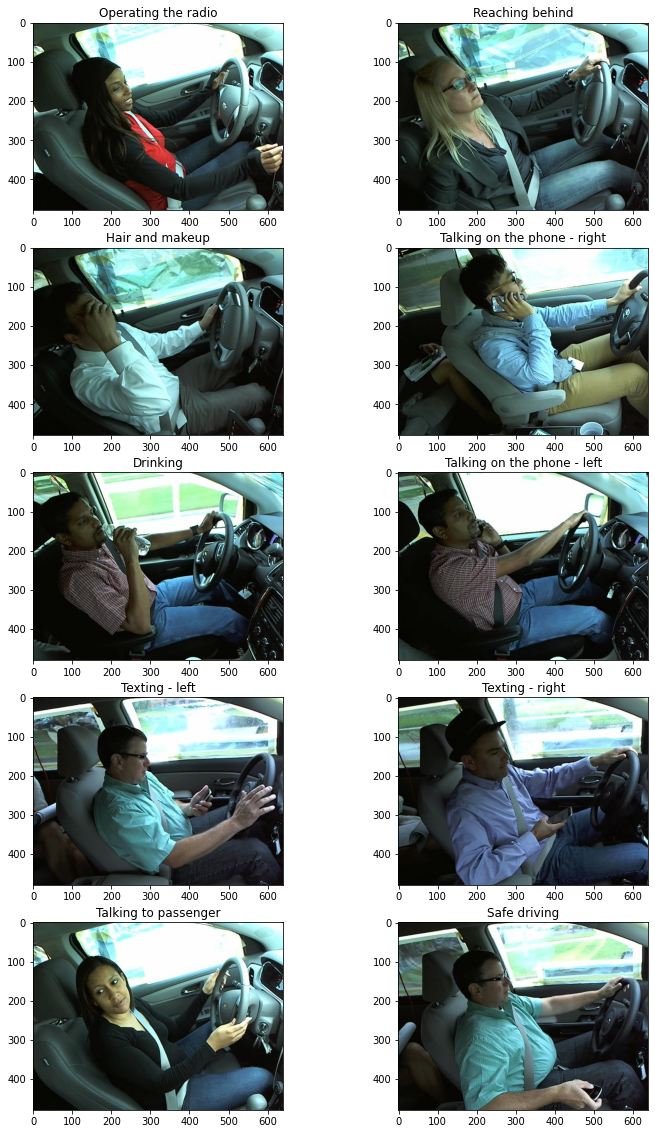

In [11]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

#### CNN Model 

Architecture :

* 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
* A flatten layer
* 2 Dense layers with Relu and Dropouts
* 1 Dense layer with softmax for the classification

In [12]:
batch_size = 40
n_epochs = 10

In [13]:
def create_model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    
    #Output
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    
    return model

In [14]:
model = create_model()

#Details about the model
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


2022-04-08 00:05:03.112085: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        1

#### Training model

In [15]:
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

print('History of the training',history.history)


2022-04-08 00:05:03.917186: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
449/449 [==============================] - 173s 379ms/step - loss: 1.1168 - accuracy: 0.6378 - val_loss: 0.4114 - val_accuracy: 0.8800
Epoch 2/10
449/449 [==============================] - 171s 380ms/step - loss: 0.2454 - accuracy: 0.9251 - val_loss: 0.0928 - val_accuracy: 0.9719
Epoch 3/10
449/449 [==============================] - 175s 390ms/step - loss: 0.1327 - accuracy: 0.9593 - val_loss: 0.0807 - val_accuracy: 0.9761
Epoch 4/10
449/449 [==============================] - 173s 384ms/step - loss: 0.1007 - accuracy: 0.9693 - val_loss: 0.0676 - val_accuracy: 0.9808
Epoch 5/10
449/449 [==============================] - 173s 384ms/step - loss: 0.0761 - accuracy: 0.9766 - val_loss: 0.0611 - val_accuracy: 0.9831
Epoch 6/10
449/449 [==============================] - 173s 386ms/step - loss: 0.0625 - accuracy: 0.9799 - val_loss: 0.0324 - val_accuracy: 0.9897
Epoch 7/10
449/449 [==============================] - 173s 384ms/step - loss: 0.0463 - accuracy: 0.9854 - val_loss: 0.0231 -

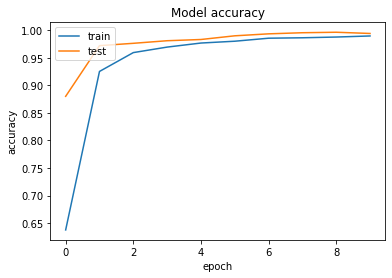

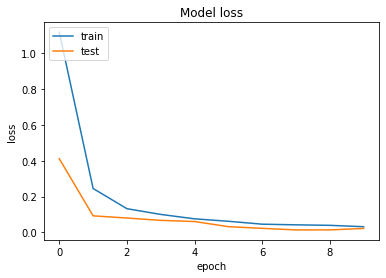

In [16]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

In [17]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [18]:
score1 = model.evaluate(x_test, y_test, verbose=1)


141/141 [==============================] - 11s 75ms/step - loss: 0.0225 - accuracy: 0.9940


In [19]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.02253054827451706
Accuracy:  99.39799308776855  %


1/1 [==============================] - 0s 379ms/step
Y prediction: [[2.8314855e-09 1.8404049e-11 1.3194833e-09 1.4689917e-09 9.0467611e-10
  9.9999833e-01 2.1459627e-11 1.6682976e-06 4.7970296e-08 9.7709032e-09]]
Predicted: Operating the radio


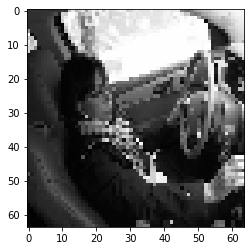

1/1 [==============================] - 0s 35ms/step
Y prediction: [[1.0923346e-09 3.0924752e-10 1.9557762e-09 3.3140479e-10 5.4798392e-09
  1.0000000e+00 2.8023321e-09 3.3567410e-10 3.8234121e-10 3.3587583e-10]]
Predicted: Operating the radio


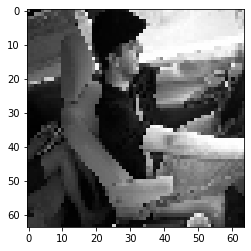

1/1 [==============================] - 0s 63ms/step
Y prediction: [[3.8864385e-02 9.1137135e-01 4.3758191e-05 5.6225015e-03 3.5922698e-05
  4.1999365e-07 2.2137591e-04 1.2385585e-04 1.9790260e-02 2.3926100e-02]]
Predicted: Texting - right


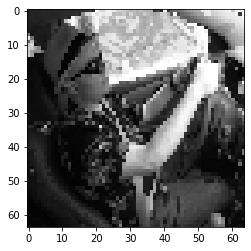

1/1 [==============================] - 0s 37ms/step
Y prediction: [[1.9961331e-07 3.6402454e-08 2.4437017e-07 3.2514116e-10 2.0763144e-08
  1.1410356e-09 4.0616534e-08 1.8182074e-07 9.9992180e-01 7.7497469e-05]]
Predicted: Hair and makeup


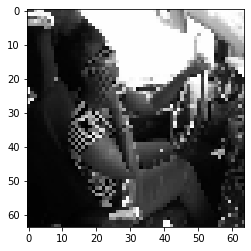

1/1 [==============================] - 0s 34ms/step
Y prediction: [[2.7725328e-04 3.3573524e-05 5.8978526e-07 9.5186931e-01 1.7858047e-02
  3.8552156e-05 9.4944444e-06 8.8472634e-06 2.7008131e-02 2.8962097e-03]]
Predicted: Texting - left


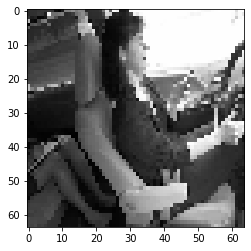

1/1 [==============================] - 0s 33ms/step
Y prediction: [[1.0586439e-06 7.2447459e-05 7.0744143e-08 9.9989235e-01 2.3210330e-06
  9.1864586e-06 4.4676663e-06 8.2541271e-07 4.2522899e-07 1.6853433e-05]]
Predicted: Texting - left


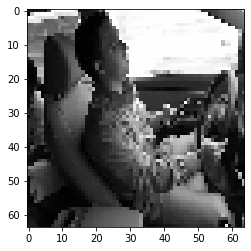

1/1 [==============================] - 0s 85ms/step
Y prediction: [[1.4519985e-05 1.0380732e-03 2.5072054e-06 2.7738806e-05 7.3773977e-06
  5.7870504e-05 4.2645158e-03 5.4336761e-06 9.9021530e-01 4.3666493e-03]]
Predicted: Hair and makeup


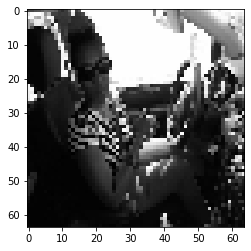

1/1 [==============================] - 0s 139ms/step
Y prediction: [[1.5107435e-04 2.7331049e-04 1.6094086e-04 2.8543521e-03 4.5327582e-05
  1.0036592e-05 1.0409874e-05 4.8539830e-05 3.1444409e-03 9.9330163e-01]]
Predicted: Talking to passenger


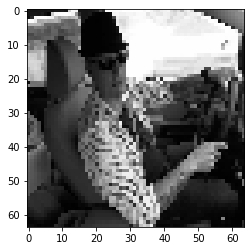

1/1 [==============================] - 0s 143ms/step
Y prediction: [[8.4624699e-05 1.9338253e-05 9.1917962e-02 1.8083783e-06 1.2448221e-06
  5.5317382e-06 9.0785420e-01 1.2965545e-05 8.2383478e-05 1.9997129e-05]]
Predicted: Drinking


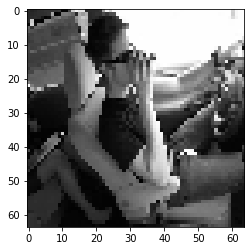

1/1 [==============================] - 0s 32ms/step
Y prediction: [[8.6807660e-08 3.3016838e-07 5.5015914e-07 1.5544174e-08 7.8256974e-08
  3.0369809e-09 1.8753153e-07 9.9999809e-01 5.0729261e-07 1.1054035e-07]]
Predicted: Reaching behind


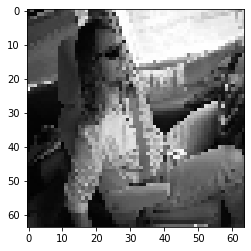

In [20]:
for i in range(10):
    plot_test_class(model, test_files, i)